In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

In [131]:
metabolite='glycine-betaine'

In [80]:
def MMETSP_groupby(df, level='Division', normalized=True):
    division_MMETSP = df.merge(mmetsp_taxonomy[level], left_index=True, right_index=True).groupby(level).sum()
    total_per_group = mmetsp_taxonomy.groupby(level)['Notes'].count()
    if normalized:
        division_MMETSP = division_MMETSP.T/total_per_group
        division_MMETSP = division_MMETSP.T
    return(division_MMETSP, total_per_group)

def create_cluster_bar(grouped_MMETSP, total_per_group, size=[12,12],
                       cutoff=False, c=5, genome=False, dropzero=False):
    grouped_MMETSP=grouped_MMETSP.dropna()
    if cutoff: 
        ii=total_per_group>c
        grouped_MMETSP= grouped_MMETSP.loc[ii]
        total_per_group=total_per_group[ii]
    if dropzero:
        ss= grouped_MMETSP[grouped_MMETSP.sum(axis=1)>0].index
        print(ss)
        grouped_MMETSP = grouped_MMETSP.loc[ss]
        total_per_group=total_per_group[ss]
    cluster = sns.clustermap(grouped_MMETSP, cmap='binary', yticklabels=1)
    cluster.fig.set_size_inches(size)
    
    # make some space to the right in the figure
    cluster.gs.update(right=0.95)
    # divide existing axes
    divider = make_axes_locatable(cluster.ax_heatmap)
    divider2 = make_axes_locatable(cluster.ax_col_dendrogram)
    # create new axes for bar plot 
    ax = divider.append_axes("right", size="20%", pad=1.7)
    # create empty space of same size as bar plot axes (don't use this space)
    nax = divider2.new_horizontal(size="20%", pad=1.7)
    target = [t.get_text() for t in np.array(cluster.ax_heatmap.get_yticklabels())]
    ind= np.array([list(grouped_MMETSP.index.values).index(t) for t in target])
    # plot bar plot in ax
    ax.barh(np.arange(len(target)), total_per_group.values[ind], color='k')
    ax.set_yticklabels([])
    ax.set_ylim(-0.5,len(grouped_MMETSP.index)-.5)
    ax.invert_yaxis()
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('top')
    if genome:
        ax.set_xlabel('Total Genomes')
    else:
        ax.set_xlabel('Total Transcriptomes')
    ax.xaxis.set_label_position('top') 
    cluster.cax.set_position([0.1, .8, .02, 0.2])
    cluster.cax.set_ylabel('Proportion Gene present')

    plt.show()
    return(cluster)

def bact_groupby(df, level='phylum', normalized=True):
    division_bact = df.merge(MarRef[level], left_index=True, right_index=True).groupby(level).sum()
    total_per_group = MarRef.groupby(level)['alt_elev'].count()
    if normalized:
        division_bact = division_bact.T/total_per_group
        division_bact = division_bact.T
    return(division_bact, total_per_group)

def calculate_all_reactions(reactions, dataframe):
    outdf = pd.DataFrame()
    for i in dataframe.index:
        for func in reactions: 
            name, val = func(dataframe.loc[i])
            outdf.loc[i, name]=val
    return(outdf)

# Pathways




In [89]:
# Glycine betaine synthesis (from choline)

def synthesis_choline(organism):
    step1 = set(['K00499','K00108','K11440'])
    step2 = set(['K00130','K14085'])
    both = set(['K17755'])

    kos = set(organism[organism==1].index)
    synthesis = 0
    if step1.intersection(kos):
        s1 = 1
    else:
        s1 = 0
    if step2.intersection(kos):
        s2 = 1
    else: 
        s2 = 0
    if s1 + s2 == 2: 
        synthesis = 1
    if both.intersection(kos):
        synthesis = 1
    return('Glycine betaine synthesis (from choline)', synthesis)
# Glycine betaine breakdown to glycine

def breakdown_glycine(organism):
    step1 = set(['K00544'])
    step2 = set(['K00309','K00315'])
    step3 = set(['K00301','K00302','K00303','K00304','K00305','K00306','K00314'])
    
    kos = set(organism[organism==1].index)
    synthesis = 0
    if step1.intersection(kos):
        s1 = 1
    else:
        s1 = 0
    if step2.intersection(kos):
        s2 = 1
    else: 
        s2 = 0
    if step3.intersection(kos):
        s3 = 1
    else:
        s3 = 0
    if s1 + s2 + s3 == 3:
        synthesis = 1
    return('Glycine betaine breakdown to glycine', synthesis)

# Glycine betaine synthesis (from glycine)
def synthesis_from_glycine(organism):
    step1 = set(['K18896','K24071'])
    step2 = set(['K13042'])
    
    kos = set(organism[organism==1].index)
    synthesis = 0
    if step1.intersection(kos):
        s1 = 1
    else:
        s1 = 0
    if step2.intersection(kos):
        s2 = 1
    else: 
        s2 = 0
    if s1 + s2 == 2:
        synthesis = 1
    return('Glycine betaine synthesis (from glycine)', synthesis)

#Glycine betaine synthesis (from sarcosine)
def synthesis_from_sacrosine(organism):
    step1 = set(['K18897'])
    
    kos = set(organism[organism==1].index)
    synthesis = 0
    if step1.intersection(kos):
        s1 = 1
    else:
        s1 = 0
    if s1 == 1:
        synthesis = 1
    return('Glycine betaine synthesis (from sarcosine)', synthesis)

transporters = {'ProX':'K02002','ProW': 'K02001','ProV': 'K02000', 'OcuC':'K05845',
                'OpuBD':'K05846','OpuA': 'K05847'}
    
reactions = [synthesis_choline, breakdown_glycine, synthesis_from_glycine, synthesis_from_sacrosine]
#Glycine betaine synthesis (from glycine)



# READ IN DATA

In [14]:
df_bact = pd.read_csv('../kofamscan/ko_tables/glycine-betaine_bact.csv', index_col=0)
df_bact.index = df_bact.index.str.split('/').str[3].str.strip('.csv')
df_mmetsp = pd.read_csv('../kofamscan/ko_tables/glycine-betaine_mmetsp.csv', index_col=0)
df_mmetsp.index=df_mmetsp.index.str.split('/').str[3].str.strip('_clean.csv')
### Other

MarRef = pd.read_csv('../MarRef_DBs/MarRef_v5.txt', sep='\t', index_col=44)
df_mmetsp.index = df_mmetsp.index.str.strip('_clean')
mmetsp_taxonomy = pd.read_csv('/vortexfs1/omics/alexander/data/mmetsp/taxonomy_v2.txt', sep='\t',
                              encoding = "ISO-8859-1", index_col='Source_ID')

# Bacterial Genomes

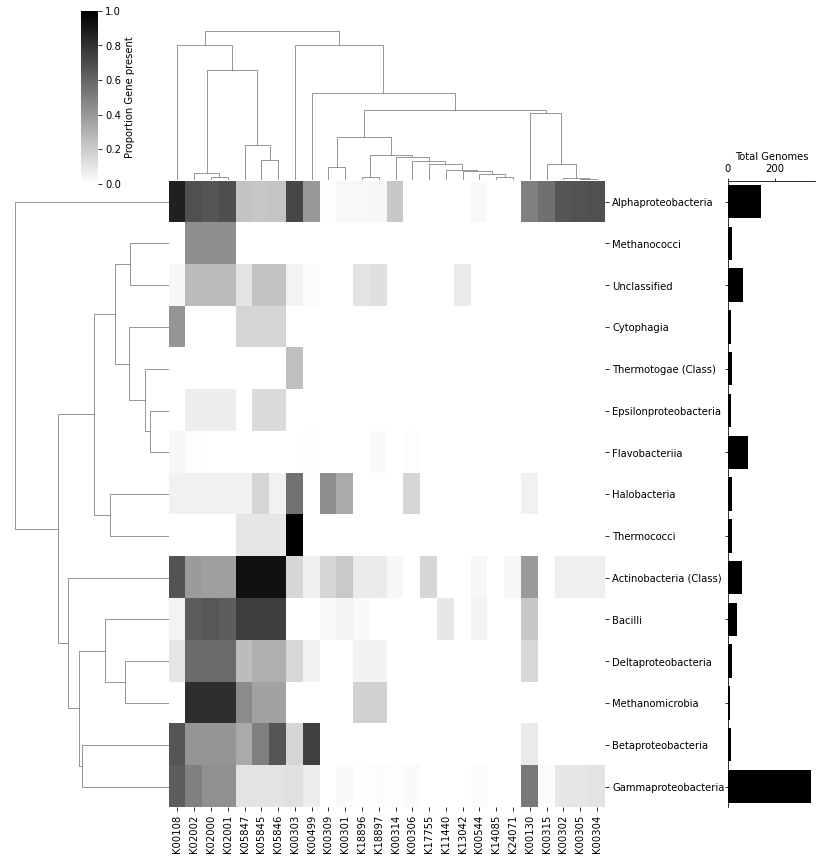

In [15]:
division_bact, total_bac_group =bact_groupby(df_bact, level='class')
create_cluster_bar(division_bact, total_bac_group, genome=True, cutoff=True, c=10)

## Reaction summary

In [82]:
reaction_bact_df = calculate_all_reactions(reactions, df_bact)
reaction_bact_df.sum()

In [107]:
transporters_bact_df = df_bact[transporters.values()]
transporters_bact_df.rename({v: k for k, v in transporters.items()}, axis=1, inplace==True)

/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/pandas/core/frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,ProX,ProW,ProV,OcuC,OpuBD,OpuA
GCF_000210915.2,0,0,0,0,0,0
GCF_000590925.1,1,1,0,0,0,0
GCF_001044335.1,0,0,0,0,0,0
GCF_000015645.1,0,0,0,0,0,0
GCF_000485905.1,1,1,1,0,0,0
...,...,...,...,...,...,...
GCF_000010405.1,0,0,0,0,0,0
GCF_000178875.2,1,1,0,0,0,0
GCF_002983865.1,1,1,1,0,0,0
GCF_000439495.1,0,0,0,0,0,0


Index(['Aeromonadales', 'Alteromonadales', 'Bacillales', 'Bacillales (Order)',
       'Bacteroidetes Order II. Incertae sedis', 'Burkholderiales',
       'Cellvibrionales', 'Chlorobiales', 'Chromatiales', 'Corynebacteriales',
       'Desulfobacterales', 'Desulfovibrionales', 'Enterobacterales',
       'Flavobacteriales', 'Haloferacales', 'Methanosarcinales',
       'Micromonosporales', 'Oceanospirillales', 'Oscillatoriales',
       'Pelagibacterales', 'Pseudomonadales', 'Pseudonocardiales',
       'Rhizobiales', 'Rhodobacterales', 'Rhodospirillales',
       'Sphingomonadales', 'Streptomycetales', 'Synechococcales',
       'Unclassified', 'Vibrionales'],
      dtype='object', name='order')


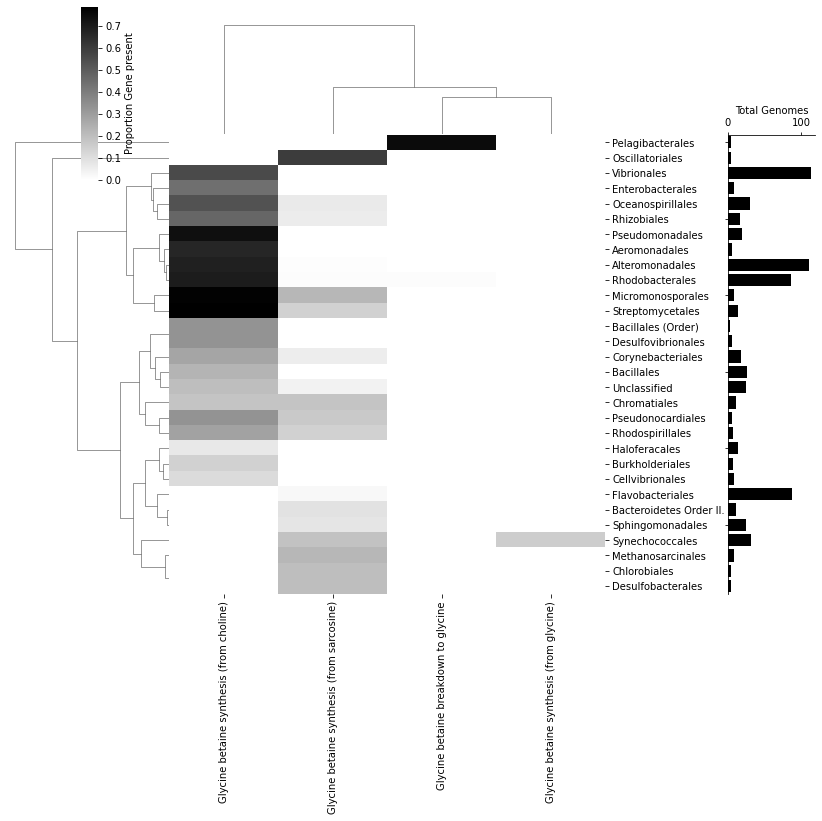

In [125]:
grouped_bact, total_bac_group  = bact_groupby(reaction_bact_df, level='order', normalized=True)
create_cluster_bar(grouped_bact, total_bac_group, dropzero=True, genome=True, cutoff=True, c=2,)

Index(['Actinobacteria (Phylum)', 'Bacteroidetes', 'Chlorobi', 'Cyanobacteria',
       'Deferribacteres (Phylum)', 'Euryarchaeota', 'Firmicutes',
       'Proteobacteria', 'Tenericutes', 'Verrucomicrobia'],
      dtype='object', name='phylum')


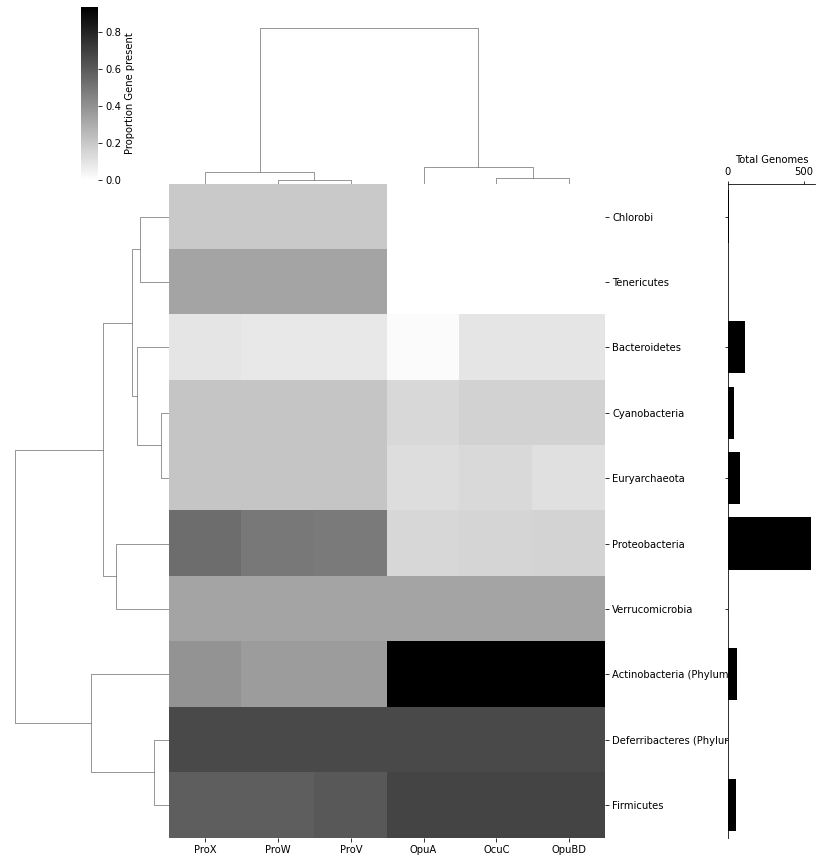

In [128]:
grouped_bact, total_bac_group  = bact_groupby(transporters_bact_df, level='phylum', normalized=True)
create_cluster_bar(grouped_bact, total_bac_group, dropzero=True, genome=True, cutoff=True, c=2,)

In [123]:
list(MarRef.columns)


['base_ID',
 'alt_elev',
 'collection_date',
 'depth',
 'env_biome',
 'env_feature',
 'env_material',
 'env_package',
 'env_salinity',
 'env_temp',
 'geo_loc_name',
 'geo_loc_name_GAZ',
 'geo_loc_name_GAZ_ENVO',
 'investigation_type',
 'lat_lon',
 'pathogenicity',
 'project_name',
 'assembly',
 'isol_growth_condt',
 'num_replicons',
 'ref_biomaterial',
 'microbe_package',
 'sample_type',
 'strain',
 'isolation_source',
 'collected_by',
 'culture_collection',
 'kingdom',
 'phylum',
 'class',
 'order',
 'family',
 'genus',
 'species',
 'taxon_lineage_ids',
 'taxon_lineage_names',
 'bacdive_id',
 'curation_date',
 'implementation_date',
 'mmp_biome',
 'silva_accession_SSU',
 'silva_accession_LSU',
 'uniprot_proteome_id',
 'assembly_accession_genbank',
 'bioproject_accession',
 'biosample_accession',
 'genbank_accession',
 'NCBI_refseq_accession',
 'NCBI_taxon_identifier',
 'annotation_provider',
 'annotation_date',
 'annotation_pipeline',
 'annotation_method',
 'annotation_software_revisi

# MMETSP 

Text(0, 0.5, 'Proportion abundance across MMETSP')

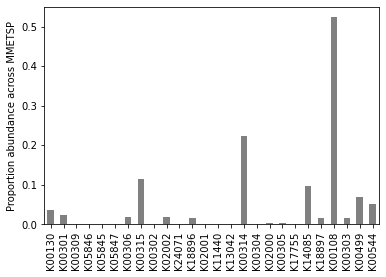

In [77]:
ax = (df_mmetsp.sum()/len(df_mmetsp)).plot(kind = 'bar', color='gray')
ax.set_ylabel('Proportion abundance across MMETSP')


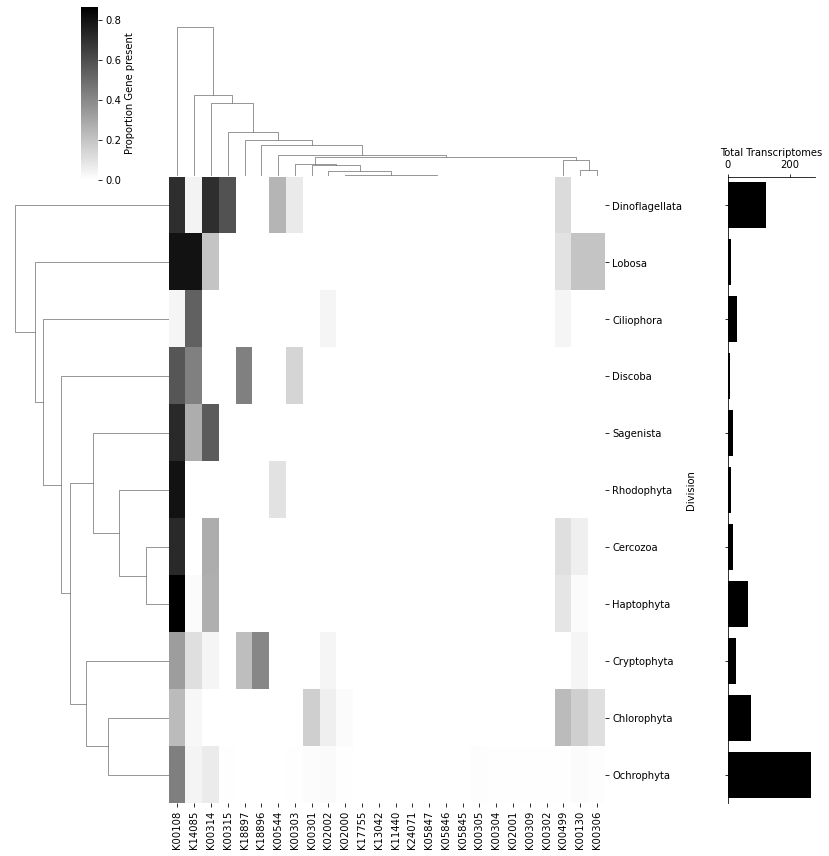

In [78]:
grouped_MMETSP, total_per_group  = MMETSP_groupby(df_mmetsp, 'Division', normalized=True)
create_cluster_bar(grouped_MMETSP, total_per_group,cutoff=True)


In [113]:
reaction_mmetsp_df = calculate_all_reactions(reactions, df_mmetsp)
reaction_mmetsp_df.sum()

Glycine betaine synthesis (from choline)      43.0
Glycine betaine breakdown to glycine          30.0
Glycine betaine synthesis (from glycine)       0.0
Glycine betaine synthesis (from sarcosine)    11.0
dtype: float64

In [118]:
transporters_mmetsp_df = df_mmetsp[transporters.values()]
transporters_mmetsp_df.rename({v: k for k, v in transporters.items()}, axis=1,inplace=True)

/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/pandas/core/frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Index(['Cercozoa', 'Chlorophyta', 'Ciliophora', 'Conosa', 'Cryptophyta',
       'Dinoflagellata', 'Discoba', 'Discosea', 'Foraminifera', 'Glaucophyta',
       'Hacrobia_X', 'Haptophyta', 'Lobosa', 'Ochrophyta', 'Sagenista',
       'Stramenopiles_X'],
      dtype='object', name='Division')


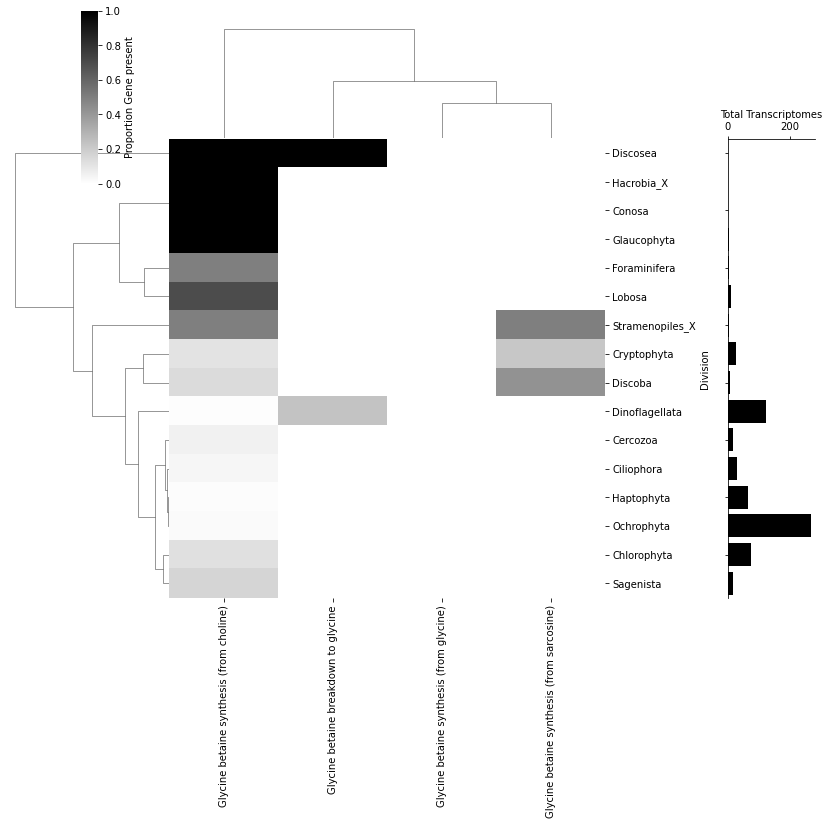

In [129]:
grouped_MMETSP, total_per_group  = MMETSP_groupby(reaction_mmetsp_df, 'Division', normalized=True)
create_cluster_bar(grouped_MMETSP, total_per_group, dropzero=True)

Index(['Chlorophyta', 'Choanoflagellida', 'Ciliophora', 'Cryptophyta',
       'Ochrophyta'],
      dtype='object', name='Division')


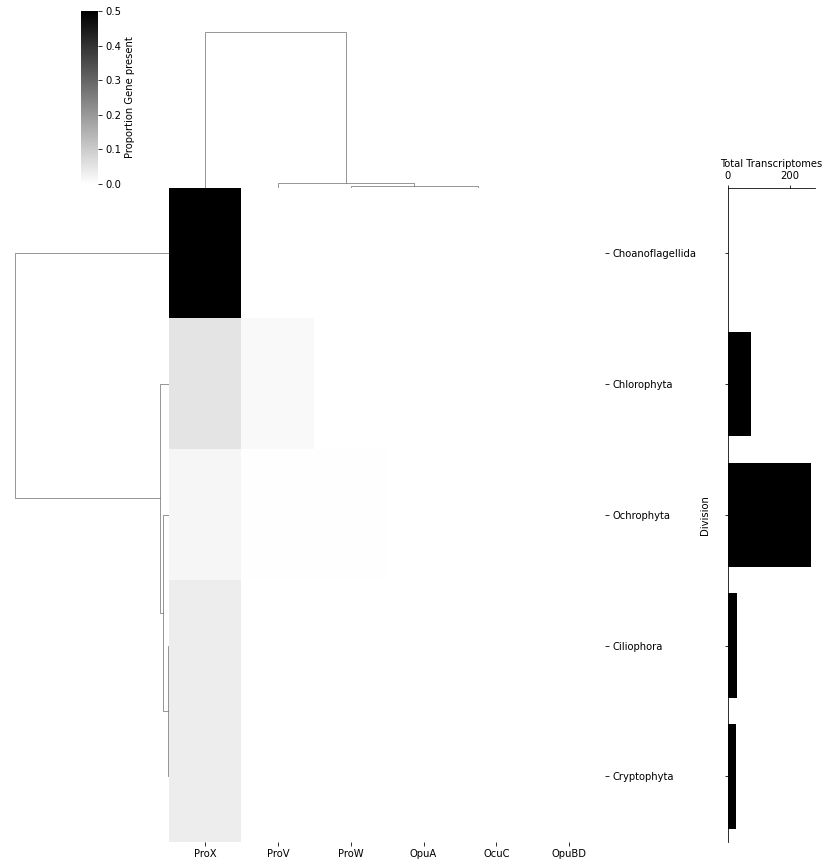

In [130]:
grouped_MMETSP, total_per_group  = MMETSP_groupby(transporters_mmetsp_df, 'Division', normalized=True)
create_cluster_bar(grouped_MMETSP, total_per_group, dropzero=True)

Text(0.5, 1.0, 'glycine-betaine')

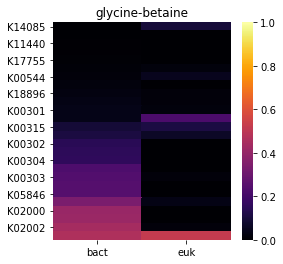

In [132]:
comp_df = pd.DataFrame()
comp_df['bact']=(df_bact.sum()/len(df_bact))
comp_df['euk']=(df_mmetsp.sum()/len(df_mmetsp))
comp_df = comp_df.sort_values(by='bact')
fig, ax = plt.subplots(1)
fig.set_size_inches(4,4)
sns.heatmap( data= comp_df, vmin=0., vmax=1., cmap='inferno')
ax.set_title(metabolite)